In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, Conv2D, MaxPooling2D, TimeDistributed
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *

#%matplotlib notebook
%matplotlib inline
sns.set()
mpl.style.use('default')


Using TensorFlow backend.


In [2]:
df = pd.read_csv('D://datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'H', combine_all_dwellings=True)

# Get all the data out of datetime
# Could also get holiday data: https://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

df['month'] = df.index.month
#df['week'] = df.index.week
#df['day'] = df.index.day
#df['year'] = df.index.year

df['month_end'] = df.index.is_month_end
df['month_start'] = df.index.is_month_start
df['quarter_end'] = df.index.is_quarter_end
df['quarter_start'] = df.index.is_quarter_start

# Select the data to use

c:\program files\python36\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Saving heatmap
Len of data:  6352


<Figure size 432x288 with 0 Axes>

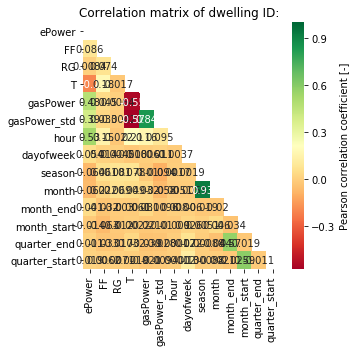

In [3]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

#data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower
data = data.drop(['ePowerReturn'], axis=1)


# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

# Preprocessing

In [4]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
data['gasPower_copy'] = data['gasPower']

data.head()

,ePower,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season,month,month_end,month_start,quarter_end,quarter_start,gasPower_copy
datetime,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1,2,True,False,False,False,6.115723
2017-02-28 13:00:00,263.656273,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1,2,True,False,False,False,5.238647
2017-02-28 14:00:00,181.913345,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1,2,True,False,False,False,2.451172
2017-02-28 15:00:00,378.613129,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1,2,True,False,False,False,3.065186
2017-02-28 16:00:00,332.392082,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1,2,True,False,False,False,8.120117


# To categorical

# To LSTM format

In [5]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.7 # This acctually is the train size, oops.
target_column = 'gasPower'

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column=target_column, scale_X=True)
X_train.shape, X_test.shape

c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


((4326, 120, 14), (1786, 120, 14))

In [6]:
t = pd.DataFrame(X_train[0, :, :])

In [7]:
t.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,1.200000e+02,1.200000e+02,120.000000
mean,0.491970,0.269442,0.051576,-1.364024,0.958272,0.000456,-0.079342,-1.065323,-1.508536,0.090066,-1.829557e-01,-1.044703e-01,-1.044703e-01,2.232152
std,1.325411,0.970611,0.779587,0.359802,1.324700,1.005724,1.176478,0.365995,0.118863,1.212148,2.787195e-17,1.393598e-17,1.393598e-17,1.984494
min,-1.311545,-1.494454,-0.169610,-2.220182,-0.858663,-1.663402,-1.499534,-2.653999,-2.024484,-0.186859,-1.829557e-01,-1.044703e-01,-1.044703e-01,-0.525019
25%,-0.511567,-0.526232,-0.169610,-1.634634,0.039015,-0.831473,-1.001221,-0.981709,-1.481381,-0.186859,-1.829557e-01,-1.044703e-01,-1.044703e-01,0.677458
50%,0.100158,0.267104,-0.169610,-1.430338,0.739244,0.000456,-0.502908,-0.981709,-1.481381,-0.186859,-1.829557e-01,-1.044703e-01,-1.044703e-01,2.023502
75%,0.875840,0.792881,-0.169610,-1.052125,1.707386,0.832384,0.992031,-0.981709,-1.481381,-0.186859,-1.829557e-01,-1.044703e-01,-1.044703e-01,3.191665
max,3.969831,2.576487,4.844544,-0.549359,6.729274,1.664313,1.490343,-0.981709,-1.481381,5.351635,-1.829557e-01,-1.044703e-01,-1.044703e-01,9.394085


# These are the "images" to work with

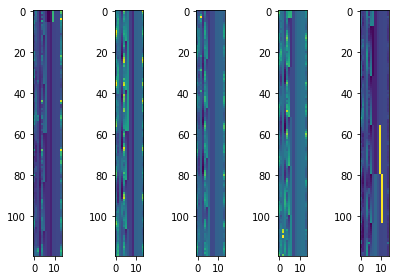

In [8]:
samples = [0, 500, 1000, 1500, 2000]

#plt.figure(figsize=(25,25))

for i, sample in enumerate(samples):
    i += 1
    plt.subplot(1,len(samples),i)
    plt.imshow(X_train[sample])


plt.tight_layout()

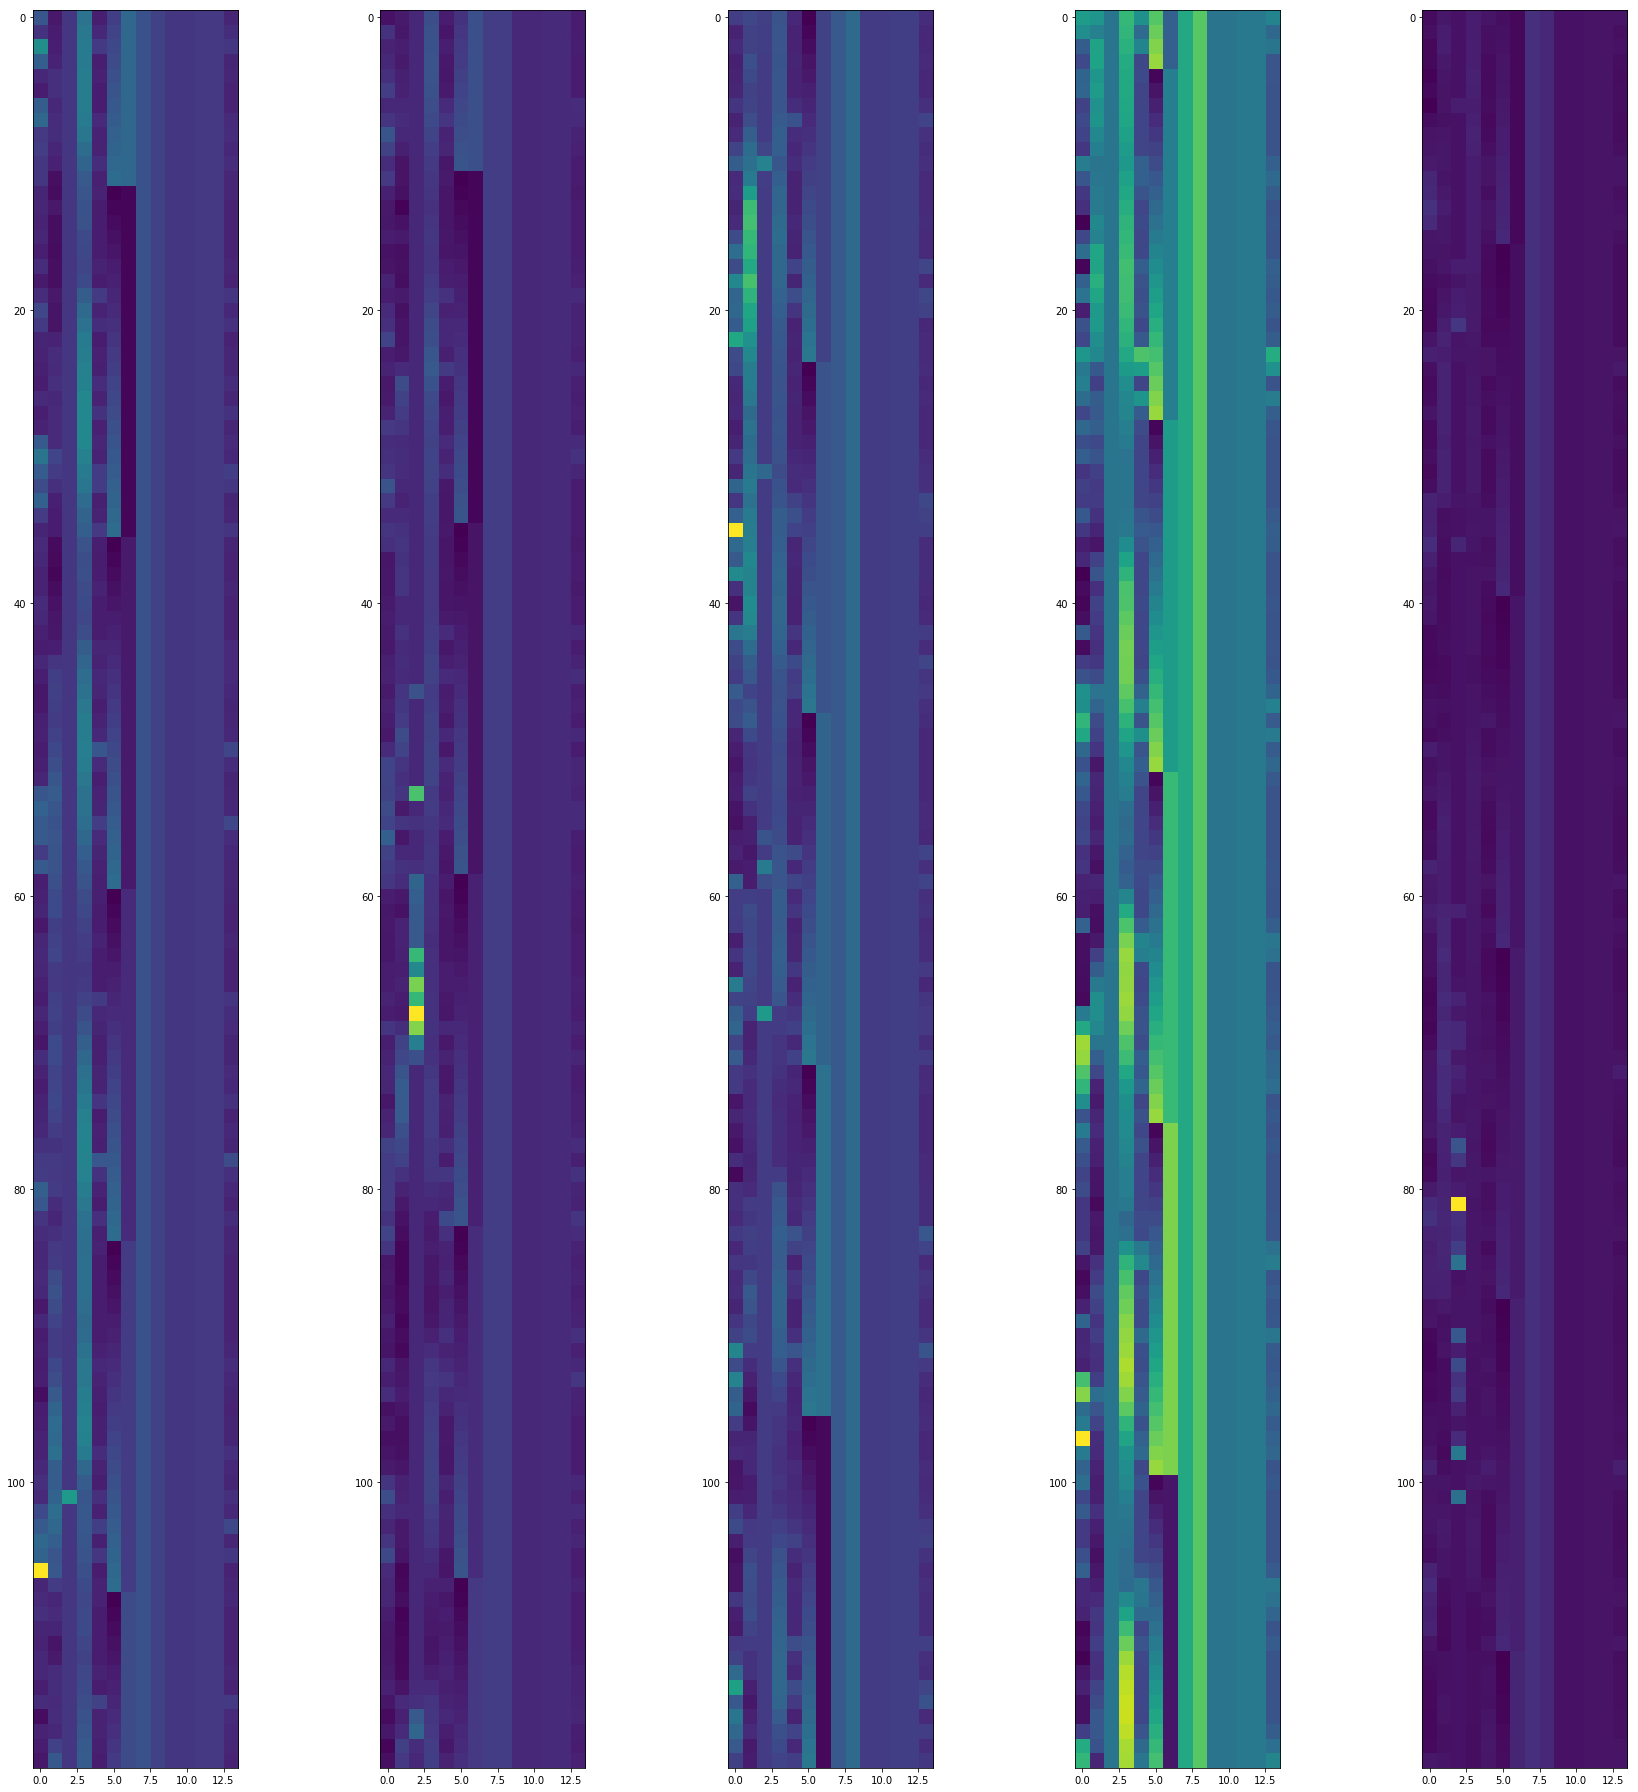

In [9]:
samples = [2500, 3000, 3500, 4000, 4300]

plt.figure(figsize=(25,25))

for i, sample in enumerate(samples):
    i += 1
    plt.subplot(1,len(samples),i)
    plt.imshow(X_train[sample])


plt.tight_layout()


In [10]:
# Make the image wider

In [11]:
a = X_train[0][:10, :5]
a.shape

(10, 5)

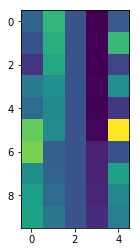

In [12]:
plt.imshow(a)

(10, 50)


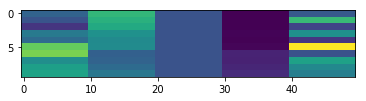

In [13]:
# 'stretch' the columns out by 10 pixels each. 
# i.e. copy the columns 10 times and add them next to each other. 
q = np.repeat(a[:,:], 10, axis=1)
print(q.shape)
plt.imshow(q)

(50, 50)


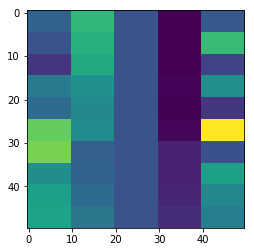

In [14]:
s = np.repeat(q[:,:], 5, axis=0)
print(s.shape)
plt.imshow(s)

# Apply this to the original 120 by 14 arrays

In [21]:
def transform_image(array, heigth, width):
    """
    Array = numpy array
    Heigth is the amount of pisels that a single pixel will be stretched out with in the height dimension.
    Width is the amount of pixels that a single pixel will be stretched out with in the width dimension.
    """
    array = array.copy()
    #print('Original shape: ', array.shape)
    array = np.repeat(array[:,:], width, axis=1)
    array = np.repeat(array[:,:], heigth, axis=0)
    #print('Transformed shape: ', array.shape)
    
    return array

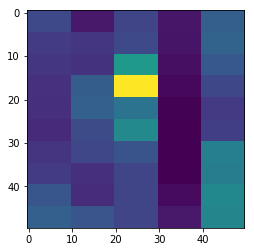

In [22]:
# Test the function. Plot the first 50 rows and columns.
plt.imshow(transform_image(X_train[1000, :, :], heigth=5, width=10)[:50, :50]) # Take

In [23]:
# What's left now is applying the above transform to all ... amount of 'images' from the dataframe.

In [24]:
reshaped = []
for i in range(X_train.shape[0]):
    reshaped.append(transform_image(X_train[i, :, :], heigth=5, width=10))
    
print('DONE')

DONE


In [25]:
np.array(reshaped).shape

(4326, 600, 140)